<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 4 - Appliquer la méthode supervisée</span>

<span style="color:orange;font-size:1.5em;font-weight:bold">Cas cluster + semi supervisé</span>

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import copy

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader
# Contient des architectures pré-entraînées (ResNet, VGG).

from sklearn.model_selection import train_test_split



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [ ]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import BrainCancerClassifier
from notebooks.utils.training import Trainer, SslManager
from notebooks.utils.data_manipulation import get_score


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
# N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# # en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# # et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10
EXPERIMENT_NAME = "experiment_01"

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet18",
    # "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":str(DEVICE),
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow">Entrainement Semi Supervisée: Pseudo labelling sur les images inconnues</span>

**On a donc vu dans un premier temps que la non supervision entrainait des résultats médiocres dans un premier temps notamment car le CNN **

C'est là qu'intervient la semi-supervision et on va pour cela utiliser le pseudo labelling. Son algorithme est le suivant:

- Prédire sur les données non labellisées .
- Sélectionner les prédictions où le modèle est le plus confiant (au-dessus d'un certain seuil).
- Ajouter ces prédictions (images + pseudo-labels) au jeu d'entraînement étiqueté.
- Ré-entraîner le modèle sur ce nouveau jeu de données augmenté.
- Répéter !

On va ici partir du clustering et regarder si le processus de pseudo labelling va améliorer les résultats ou non.

In [9]:
# gestionnaire de sauvegarde
ssl_with_cluster_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="ssl_with_cluster"
)

<span style="color:blue;font-size:1.2em;font-weight:bold">Chargement des résultats du clustering</span>

<span style="color:purple;font-weight:bold">Configuration</span>

On va partir du résultats du cas **pca-kmeans** précédent qui va servir "d'initialisation"

In [10]:
# on charge la donnée (issu de analyzer du non supervisé)
df_cluster = pd.read_parquet(SAVE_PATH/"unsupervised"/EXPERIMENT_NAME/"df_cluster.parquet")

In [ ]:
ssl_with_cluster_config = project_config | {
    "reset":True,
    "max_pseudo_iter":10,
    "ssl_with_cluster_learning_rate":1e-4,
    "init_threshold":0.95,
    "final_threshold":0.85,
    'ssl_with_cluster_n_epoch':N_EPOCH,
    
}

ssl_with_cluster_manager.save_config(ssl_with_cluster_config)


# Instanciation de l'objet de redim, norm, augmentation
base_transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE)

In [12]:
# Remise en place du LOADER DE VALIDATION (SET DE VALIDATION)

# juste par confort
X = avec_labels_path
y = avec_labels_encoding

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Set de validation
test_dataset = ImagesToDataset(X_test, y_test, transform=base_transform.preproc(train=False))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<span style="color:purple;font-weight:bold">Phase d'initialisation</span>

In [13]:
# dataset et dataloader d'initialisation (la composition supposée par le cluster)

# On s'assure de ne prendre que ce qui a été labelliser (fort et faible) sur le jeu
df_init = df_cluster[df_cluster['cluster_pseudo_label'] != -1]

X_init = [Path(p) for p in df_init['path'].tolist()]
y_init = df_init['cluster_pseudo_label'].astype(int).tolist()

idataset = ImagesToDataset(
    X_init, 
    y_init, 
    transform=base_transform.preproc(train=True, strong_augment=True)
)
iloader = DataLoader(idataset, batch_size=BATCH_SIZE, shuffle=True)

**Rappel**: pca_kmeans etc... sont les groupements brutes des algo de clustering

In [14]:
# Me^me pre traitement sur les données non labellisées (pas de split ni d'augment evidemment)
Xu = sans_label_path
yu = [-1]*len(sans_label_path)
# dataset et loader
udataset = ImagesToDataset(Xu, yu, transform=base_transform.preproc(train=False))
uloader = DataLoader(udataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Instanciation du classificateur + déplacement sur le device
model_classif = BrainCancerClassifier(
    num_classes=1, 
    model_name=ssl_with_cluster_config['model']
).to(DEVICE)
# L'optimiseur ajuste les poids du modèle. Contient le learning_rate et les gradients.
# On met un learning rate (lr) faible car fine-tuning 
# (on ne veut pas détruire ce que ResNet sait déjà).
optimizer = optim.Adam(
    model_classif.parameters(), 
    lr=ssl_with_cluster_config["ssl_with_cluster_learning_rate"]
)
# On instancie la loss suivant le set de clustering
num_sains = y_init.count(0)
num_cancers = y_init.count(1)
# Calcul du ratio (poids pour la classe positive)
# On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Instanciation de la pipeline de training
trainer = Trainer(
    model_classif, 
    DEVICE, 
    criterion, 
    optimizer
)

In [ ]:
# Boucle d'entraînement
temp_best_f2 = 0.0
temp_best_prauc = 0.0
temp_best_ece = 1.0
temp_best_score = get_score(temp_best_f2,temp_best_ece,temp_best_prauc,mode = "cluster")

print(f" Initialisation d'entraînement sur le set issu du cluster ({len(X_init)} images)")
for epoch in range(ssl_with_cluster_config['ssl_with_cluster_n_epoch']):
    # ================= ENTRAINEMENT ================
    train_loss = trainer.train_epoch(iloader)
    # ====================== EVAL =====================
    results = trainer.eval_metrics(test_loader) # on evalue sur les 20 images restantes label
    ece = trainer.calculate_ece(results['raw_data']) #type:ignore On estime la fiabilité de la confiance
    print(
        f"Epoch {epoch+1}/{ssl_with_cluster_config['ssl_with_cluster_n_epoch']} | Loss: {train_loss:.4f}"
        f" | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}"
    )
    # ================= SAUVEGARDE INDIVIDUELLE DES MÉTRIQUES =============
    temp_metrics ={
            "epoch" : epoch+1,
            "train_loss" : train_loss,
            # "f2" : results["f2"],
            # "precision" : results["precision"],
            # "recall":results["recall"],
            "ece":ece, # Fiabilité de la confiance du modèle
            # "accuracy": results["accuracy"], # Exactitude
            # "auc": results["auc"],# Capacité a séparer les labels
            # "pr_auc": results["pr_auc"], # Précision sur les positifs
            **{key: value for key, value in results.items()}
        }
    ssl_with_cluster_manager.log_metrics(temp_metrics)
    
    # ================ CHECKPOINT (SAVE SI MEILLEUR MODELE JUSQU'ICI) ===========
    temp_f2 = results["f2"]
    temp_prauc = results['pr_auc']
    temp_score = get_score(temp_f2,ece,temp_prauc,mode = "cluster")
    
    if temp_score >= temp_best_score:
    # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
    #     if ece <= temp_best_ece*1.25:
            # réalise un checkpoint suivant la condition f2 (sauvegarde comme best ou pas)
        ssl_with_cluster_manager.save_checkpoint({
            'epoch': epoch + 1,
            'train_loss':train_loss,
            'state_dict': model_classif.state_dict(), # ou plus rigoureux: trainer.model.state_dict()
            'optimizer': optimizer.state_dict(),# ou plus rigoureux: trainer.optimizer.state_dict()
            'f2': temp_f2,
            'pr_auc': temp_prauc,
            'ece':ece,
            'config': ssl_with_cluster_config
        },is_best=True)
        
        # MAJ des métriques
        # temp_best_f2 = max(temp_f2, temp_best_f2)
        temp_best_f2 = temp_f2
        temp_best_prauc = temp_prauc
        temp_best_ece = ece
        temp_best_score = temp_score

 Initialisation d'entraînement sur le set issu du cluster (1506 images)
Epoch 1/10 | Loss: 0.6119 | f2: 0.6522 | pr_auc: 0.8844 | ece: 0.2174
Epoch 2/10 | Loss: 0.5645 | f2: 0.6522 | pr_auc: 0.9169 | ece: 0.2190
Epoch 3/10 | Loss: 0.5187 | f2: 0.6522 | pr_auc: 0.9007 | ece: 0.2990
Epoch 4/10 | Loss: 0.4779 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1967
Epoch 5/10 | Loss: 0.4530 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1632
Epoch 6/10 | Loss: 0.4245 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1839
Epoch 7/10 | Loss: 0.4107 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1611
Epoch 8/10 | Loss: 0.3872 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1497
Epoch 9/10 | Loss: 0.3824 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1463
Epoch 10/10 | Loss: 0.3744 | f2: 0.6522 | pr_auc: 0.9248 | ece: 0.1945


In [ ]:
# ============== MEILLEUR MODELE POUR AFFICHAGE METRIQUES ===========
# On recharge le meilleur état trouvé pour la suite (SSL)
model_path = ssl_with_cluster_manager.ckpt_dir / "best_model.pth"
checkpoint = torch.load(model_path, weights_only=False)
model_classif.load_state_dict(checkpoint['state_dict'])
print(f"Meilleur modèle chargé - epoch: {checkpoint['epoch']} | f2: {checkpoint['f2']:.4f}"
    f"| pr_auc: {checkpoint['pr_auc']:.4f} | ece: {checkpoint['ece']:.4f}")

# Evaluation finale
ssl_with_cluster_metrics = trainer.eval_metrics(test_loader)
phase_init = pd.DataFrame([ssl_with_cluster_metrics])
display(phase_init)

In [ ]:
# =============== NETTOYAGE ===============
del (test_dataset,
    train_loss, results
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Cette première itération à partir du set de clustering a grandement amélioré les scores biens qu'ils restent relativement moyen (f2 autour de 0.6 et ece autour de 0.15).

<span style="color:purple;font-weight:bold">Phase SSL</span>

In [ ]:
# La mise en place globale du pseudo labelling
max_pseudo_iteration = ssl_with_cluster_config['max_pseudo_iter']
reset = True # Si on repart d'une pipeline neuve (Cold start) ou pas (Continous Fine Tuning)
# Cold start permet d'eviter l'accumulation d'erreurs et l'oubli (stacker les biais et 
# oublier les fortement labellisés) MAIS coût d'entrainement plus elevé

# Garde fou pour éviter dérive
max_stop = 5

# # décroissance du threshold, on assoupli le threshold a mesure des iterations
decay = np.linspace(
    ssl_with_cluster_config["init_threshold"],
    ssl_with_cluster_config["final_threshold"],
    max_pseudo_iteration+1
)

In [ ]:
counter = 0
stop = 0
temp_best_f2 = checkpoint['f2'] # On repart du f2 de la baseline (supervisée)
temp_best_prauc = checkpoint['pr_auc'] # On repart de l'aucpr de la baseline (supervisée)
temp_best_ece = checkpoint['ece']
temp_best_score = get_score(temp_best_f2,temp_best_ece, temp_best_prauc)
ece = checkpoint['ece']
del checkpoint
gc.collect()

while counter <= max_pseudo_iteration:
    # On s'assure que le threshold est bon
    trainer.threshold = decay[counter]
    
    # ======== PRÉDICTION SUR SET INCONNU ET GET DES PSEUDO LABELS/PATHS =========
    # IMPORTANT: AVANT D'ETRE ECRASE, ON RECOLTE PSEUDO_X ET Y! CE N'EST PAS ULOADER QUI DOIT
    # ETRE MAJ MAIS TRAINER QUI SERA MODIFIE (NOUVEAU PSEUDO_X ET PSEUDO_Y) AVANT SON RESET.
    # MODEL_CLASSIF ET OPTIMIZER DE LA PARTIE SUPERVISÉE ONT POUR SEULE UTILITÉ INFLUENCÉ TRAINER
    print(f"=== iter {counter} | pseudo labelling (seuil {decay[counter]:.4f}) ===")
    pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
    print(f"Pseudo-labels générés : {len(pseudo_X)}")
    
    # ============= EMPECHE BOUCLE INUTIE ET DERIVE IMPORTANTE =================
    if len(pseudo_X) == 0 or ece >= 0.5: #type:ignore  Ajout de l'ece pour eviter le biais de confirmation
        print("Confiance rompue pour relancer l'entrainement")
        break
    
    
    # ========== MISE EN PLACE DU DATALOADER ================ 
    # (On NE STACK PAS les pseudo et on REPART TOUJOURS du jeu labellisé de base!)
    new_X_train = X_train + [Path(x) for x in pseudo_X]
    new_y_train = y_train + pseudo_y
    
    # dataset et loader, on applique des transformations et shuffle. Pour corser le travail et
    # rendre l'entrainement plus efficace, on applique ici des transformations FORTES VS FAIBLE
    # pour le train du supervisée
    new_train_dataset = ImagesToDataset(
        new_X_train,
        new_y_train,
        transform=base_transform.preproc(train=True,strong_augment=True)
    )
    new_train_loader = DataLoader(
        new_train_dataset,
        BATCH_SIZE,
        shuffle=True
    )
    
    # =================== REGUL PONDERATION DU CRITERION =================
    # Si les pseudo labels déséquilibrent trop le jeu d'entrainement, il faut reponderer criterion
    # Compter les occurrences dans le nouveau set d'entraînement
    num_sains = new_y_train.count(0)
    num_cancers = new_y_train.count(1)
    # Calcul du ratio (poids pour la classe positive)
    # On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
    new_pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
    new_criterion = nn.BCEWithLogitsLoss(pos_weight=new_pos_weight)
    
    # ================ MISE EN PLACE DU TRAINER =========================
    if reset:
        # ============ COLD START ==============
        # NEW START, on repart d'un nouveau modele et nouvel optimiseur (et entrainement)
        # ========================= Cleaning ================
        if 'new_trainer' in locals():
            del new_model_classif, new_optimizer, new_trainer
            gc.collect() # Libère la RAM CPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache() # Libère la VRAM GPU
        # =========================================
        # CHARGEMENT DES POIDS DU MEILLEUR MODÈLE PRÉCÉDENT
        new_model_classif = BrainCancerClassifier(
            num_classes=1,
            model_name=ssl_with_cluster_config['model']
        ).to(DEVICE)
        new_model_classif.load_state_dict(copy.deepcopy(best_trainer_state))
        
        new_optimizer = optim.Adam(
            new_model_classif.parameters(), 
            lr=ssl_with_cluster_config["ssl_with_cluster_learning_rate"]
        )
        # new_criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit + label smoothing
        new_trainer = Trainer(
            new_model_classif, 
            DEVICE, 
            new_criterion, 
            new_optimizer, 
            threshold=decay[counter]
        )
    else:
        # ============ CONTNOUS FINE TUNING ============
        # ON GARDE LE MEME TRAINER, REDUCTION SEUIL + LEARNING_RATE pour ne pas détruire 
        # les poids déjà appris.
        new_trainer = trainer
        new_trainer.threshold = decay[counter] # MAJ threshold
        new_trainer.criterion.pos_weight = new_pos_weight # MAJ Pondération
        # La boucle est obligatoire pour modifier le LR dans PyTorch
        for param_group in new_trainer.optimizer.param_groups:
            param_group['lr'] = ssl_with_cluster_config["ssl_with_cluster_learning_rate"] / 10
    
    # =============== ENTRAINEMENT ====================================
    IMPROVED_FLAG = False
    print(f"====== iter {counter} | seuil {decay[counter]:.4f} | {len(new_X_train)} images =======")
    for epoch in range(ssl_with_cluster_config['ssl_with_cluster_n_epoch']):
        train_loss = new_trainer.train_epoch(new_train_loader) # le nouveau set de train
        # ====================== EVAL =====================
        results = new_trainer.eval_metrics(test_loader) # ON RESTE SUR LE MEME SET D'EVAL!
        ece = new_trainer.calculate_ece(results['raw_data'])# type:ignore
        print(f"Epoch {epoch+1}/{ssl_with_cluster_config['ssl_with_cluster_n_epoch']} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}")
        # =============== CHECKPOINT =====================================
        temp_metrics = {
            "epoch":epoch+1,
            "iteration":counter,
            "threshold":decay[counter],
            "n_pseudo":len(pseudo_X),
            "train_loss":train_loss,
            "ece":ece, # Fiabilité de la confiance du modèle
            **{key: value for key, value in results.items()}
        }
        ssl_with_cluster_manager.log_metrics(temp_metrics)
        
        temp_f2 = results['f2']
        temp_prauc = results['pr_auc']
        temp_score = get_score(temp_f2,ece,temp_prauc)

        if temp_score > temp_best_score:
        # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
        #     if temp_ece <= temp_best_ece:
                
            # On sauvegarde l'état du modèle et les pseudos qui ont fonctionné
            # best_trainer_state = copy.deepcopy(new_trainer.model.state_dict())
            # Moins gourmand en RAM
            best_trainer_state = {
                key: value.cpu().clone() for key, value 
                in new_trainer.model.state_dict().items()
            }
            temp_best_f2 = temp_f2
            # QUE pour le checkpoint!
            temp_best_prauc = temp_prauc
            IMPROVED_FLAG = True
            temp_best_ece = ece
            temp_best_score = temp_score
            
            temp_state = {
                'epoch':epoch+1,
                'iteration':counter,
                'threshold':decay[counter],
                'n_pseudo':len(pseudo_X),
                'train_loss':train_loss,
                # new_model_classif.state_dict() == new_trainer.model.state_dict() 
                # donc on peut raccourcir ici car pointent au même objet en mémoire
                'state_dict': new_model_classif.state_dict(), 
                # new_optimizer.state_dict(), si pas de cold start: plante car n'existe pas
                'optimizer': new_trainer.optimizer.state_dict(),
                'f2': temp_best_f2,
                'pr_auc': temp_best_prauc,
                'ece':temp_best_ece,
                'config': ssl_with_cluster_config
            }
            ssl_with_cluster_manager.save_checkpoint(temp_state, is_best=True)
            ssl_with_cluster_manager.save_weak_labels(pseudo_X, pseudo_y)
                
    if not IMPROVED_FLAG: # On a fait la boucle d'entrainement mais pas d'amélioration sur l'iteration
        # ============= CAS LAMBDA =============
        # Rollback : on recharge les poids du meilleur modèle dans le trainer actuel
        new_trainer.model.load_state_dict(best_trainer_state)
        stop+=1
    else:
        stop = 0 # on reinitialise le compteur de stagnation
    if stop >= max_stop:
        print('Arrêt prématuré, plus de progression')
        break
    
    trainer = new_trainer
    counter+=1
    
    # ========================= Cleaning ================
    # Nettoyage de fin d'itération
    del new_train_loader
    gc.collect()
    if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
# =========================================

=== iter 0 | pseudo labelling (seuil 0.9000) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.16it/s]


Pseudo-labels générés : 51
====== iter 0 | seuil 0.9000 | 131 images =======
Epoch 1/10 | Loss: 0.5561 | f2: 0.6522 | pr_auc: 0.9219 | ece: 0.1807
Epoch 2/10 | Loss: 0.5599 | f2: 0.7447 | pr_auc: 0.9198 | ece: 0.1344
Epoch 3/10 | Loss: 0.5792 | f2: 0.7447 | pr_auc: 0.9156 | ece: 0.1348
Epoch 4/10 | Loss: 0.5635 | f2: 0.7447 | pr_auc: 0.9087 | ece: 0.1417
Epoch 5/10 | Loss: 0.5496 | f2: 0.7447 | pr_auc: 0.9137 | ece: 0.1808
Epoch 6/10 | Loss: 0.5360 | f2: 0.6522 | pr_auc: 0.9058 | ece: 0.1556
Epoch 7/10 | Loss: 0.5789 | f2: 0.7447 | pr_auc: 0.9198 | ece: 0.1328
Epoch 8/10 | Loss: 0.5809 | f2: 0.7447 | pr_auc: 0.9248 | ece: 0.1651
Epoch 9/10 | Loss: 0.5447 | f2: 0.7447 | pr_auc: 0.9248 | ece: 0.1629
Epoch 10/10 | Loss: 0.5535 | f2: 0.7447 | pr_auc: 0.9281 | ece: 0.1646
=== iter 1 | pseudo labelling (seuil 0.8950) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:16<00:00,  1.16it/s]


Pseudo-labels générés : 131
====== iter 1 | seuil 0.8950 | 211 images =======
Epoch 1/10 | Loss: 0.2232 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1788
Epoch 2/10 | Loss: 0.2275 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.2301
Epoch 3/10 | Loss: 0.2270 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1538
Epoch 4/10 | Loss: 0.2424 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1575
Epoch 5/10 | Loss: 0.2188 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1707
Epoch 6/10 | Loss: 0.2129 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1531
Epoch 7/10 | Loss: 0.2176 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1445
Epoch 8/10 | Loss: 0.2338 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1476
Epoch 9/10 | Loss: 0.2204 | f2: 0.7447 | pr_auc: 0.9426 | ece: 0.1964
Epoch 10/10 | Loss: 0.2099 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1527
=== iter 2 | pseudo labelling (seuil 0.8900) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:12<00:00,  1.21it/s]


Pseudo-labels générés : 98
====== iter 2 | seuil 0.8900 | 178 images =======
Epoch 1/10 | Loss: 0.2879 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1547
Epoch 2/10 | Loss: 0.2799 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.2212
Epoch 3/10 | Loss: 0.2999 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1345
Epoch 4/10 | Loss: 0.2906 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1717
Epoch 5/10 | Loss: 0.2882 | f2: 0.7447 | pr_auc: 0.9344 | ece: 0.1820
Epoch 6/10 | Loss: 0.3173 | f2: 0.7447 | pr_auc: 0.9426 | ece: 0.1785
Epoch 7/10 | Loss: 0.2938 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1726
Epoch 8/10 | Loss: 0.2774 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1702
Epoch 9/10 | Loss: 0.2954 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1977
Epoch 10/10 | Loss: 0.2791 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1437
=== iter 3 | pseudo labelling (seuil 0.8850) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:12<00:00,  1.21it/s]


Pseudo-labels générés : 124
====== iter 3 | seuil 0.8850 | 204 images =======
Epoch 1/10 | Loss: 0.2723 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1485
Epoch 2/10 | Loss: 0.2685 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1761
Epoch 3/10 | Loss: 0.2668 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1719
Epoch 4/10 | Loss: 0.2592 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1735
Epoch 5/10 | Loss: 0.2628 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1537
Epoch 6/10 | Loss: 0.2626 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1749
Epoch 7/10 | Loss: 0.2683 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1718
Epoch 8/10 | Loss: 0.2770 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1619
Epoch 9/10 | Loss: 0.2541 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2318
Epoch 10/10 | Loss: 0.2802 | f2: 0.7447 | pr_auc: 0.9556 | ece: 0.2037
=== iter 4 | pseudo labelling (seuil 0.8800) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:12<00:00,  1.21it/s]


Pseudo-labels générés : 148
====== iter 4 | seuil 0.8800 | 228 images =======
Epoch 1/10 | Loss: 0.2617 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.2168
Epoch 2/10 | Loss: 0.2645 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.2341
Epoch 3/10 | Loss: 0.2617 | f2: 0.7447 | pr_auc: 0.9456 | ece: 0.1490
Epoch 4/10 | Loss: 0.2624 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1543
Epoch 5/10 | Loss: 0.2675 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1785
Epoch 6/10 | Loss: 0.2567 | f2: 0.6522 | pr_auc: 0.9456 | ece: 0.1728
Epoch 7/10 | Loss: 0.2617 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1755
Epoch 8/10 | Loss: 0.2619 | f2: 0.7447 | pr_auc: 0.9374 | ece: 0.2178
Epoch 9/10 | Loss: 0.2495 | f2: 0.7447 | pr_auc: 0.9426 | ece: 0.2057
Epoch 10/10 | Loss: 0.2671 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1703
=== iter 5 | pseudo labelling (seuil 0.8750) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:12<00:00,  1.21it/s]


Pseudo-labels générés : 171
====== iter 5 | seuil 0.8750 | 251 images =======
Epoch 1/10 | Loss: 0.2475 | f2: 0.6522 | pr_auc: 0.9374 | ece: 0.1848
Epoch 2/10 | Loss: 0.2451 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1508
Epoch 3/10 | Loss: 0.2442 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1441
Epoch 4/10 | Loss: 0.2472 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1483
Epoch 5/10 | Loss: 0.2344 | f2: 0.6522 | pr_auc: 0.9344 | ece: 0.1485
Epoch 6/10 | Loss: 0.2542 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1718
Epoch 7/10 | Loss: 0.2477 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1694
Epoch 8/10 | Loss: 0.2555 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1624
Epoch 9/10 | Loss: 0.2437 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1450
Epoch 10/10 | Loss: 0.2543 | f2: 0.6522 | pr_auc: 0.9426 | ece: 0.1589
Arrêt prématuré, plus de progression


In [ ]:
# score de test
test_results = torch.load(ssl_with_cluster_manager.ckpt_dir / "best_model.pth", weights_only=False)
print(f"iteration : {test_results['iteration']} | epoch : {test_results['epoch']} |"
    f"f2 : {test_results['f2']:.4f} | pr_auc : {test_results['pr_auc']:.4f}"
    f"| ece : {test_results['ece']:.4f} | threshold : {test_results['threshold']:.4f}")

F2-Score vérifié : 0.7447


In [ ]:
# coherence des pseudo labels
df_pseudo = pd.read_parquet(SAVE_PATH/"ssl_with_cluster"/EXPERIMENT_NAME/"weak_labels.parquet")
print(df_pseudo['label'].value_counts())

label
0    41
1    10
Name: count, dtype: int64


--- Statistiques des scores ---
Médiane : 0.6783
Moyenne : 0.5641
Classe incertaine (0.3-0.7) : 315
Nb de cancer (0.8999999999999999)  : 46
Nb de sain (0.10000000000000009)  : 18
plot_probas sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/notebooks


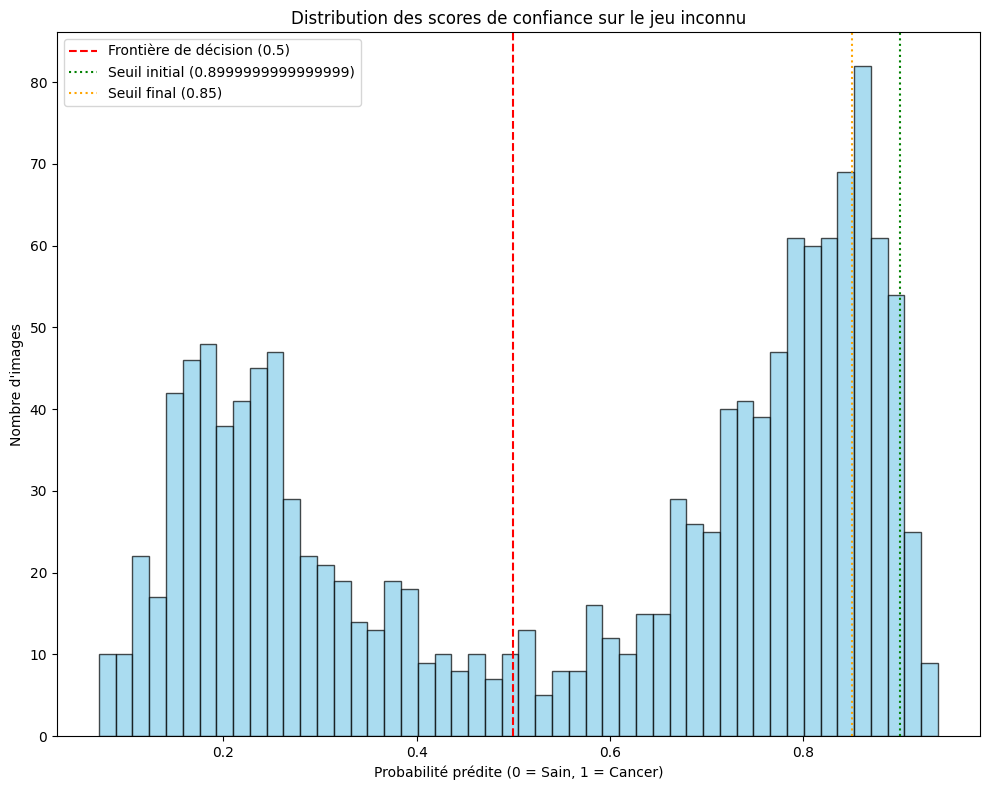

In [ ]:
# from notebooks.utils.analyze_ssl import analyze_confidence
from notebooks.utils.plotting.make_model_plots import plot_confidence

all_unlabeled_probs = []
with torch.no_grad():
    for imgs, _, _ in uloader:
        logits = new_trainer.model(imgs.to(DEVICE))
        all_unlabeled_probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())

all_unlabeled_probs = np.array(all_unlabeled_probs)

plot_confidence(
    probas=all_unlabeled_probs,# results['raw_data']['probs'],
    threshold=test_results['threshold'],#type:ignore
    stats=True
)

Dans la grande boucle ssl, dès la deuxième itération on a notre meilleur modèle avec une amélioration du f2 (on pas vers 0.74) ainsi que de l'ece (0.13) et un PR AUC qui reste très bon (0.9). 

Le modèle reste indécis globalement (confiance supérieure à 90% sur 64 images seulement donc moins de 5% du jeux inconnu)

In [ ]:
del (test_results, df_pseudo, all_unlabeled_probs, 
     trainer, model_classif, optimizer,
     new_model_classif, new_optimizer, new_trainer,
     udataset, uloader, test_loader, base_transform, 
     ssl_with_cluster_config, ssl_with_cluster_manager
    )
gc.collect()